# FOOD DEMAND FORECAST

In [1]:
''' This script define the problem, discover, develop and deploy the solution for food demand'''
_______author_______= 'Khanh Ho'
_______email________= 'hpk0304@gmail.com'
_____data_source____= 'Analytics Vidhya'

# PART 1 - DEFINE THE PROBLEM 

**This project has 2 targets:**
1. Feature importance
2. Forward prediction for the next 10 weeks

In [2]:
# import the sources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn as sk
import warnings

from pandas import DataFrame
from matplotlib import pyplot
from pylab import rcParams
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

%matplotlib inline

# PART 2 - DISCOVER 

## a. Load the data

In [3]:
train_df = pd.read_csv(r'D:\Projects_jupyter\DSDJ\Projects\Food demand\data\train.csv')
meal_info_df = pd.read_csv(r'D:\Projects_jupyter\DSDJ\Projects\Food demand\data\meal_info.csv')
fulfilment_center_info_df = pd.read_csv(r'D:\Projects_jupyter\DSDJ\Projects\Food demand\data\fulfilment_center_info.csv')

## b. Examine the data

In [4]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
fulfilment_center_info_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [6]:
meal_info_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


## Argument data with additional columns

In [7]:
## Merge dataset
train_df = pd.merge(train_df,fulfilment_center_info_df, on = 'center_id')
train_df = pd.merge(train_df, meal_info_df, on = 'meal_id')
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [8]:
# Apply the log of num_orders to detect the large outliers
train_df['num_orders_log'] = np.log(train_df.num_orders)

## Separate numerical and categorical data

In [9]:
train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'num_orders_log'],
      dtype='object')

In [10]:
numeric_cols = ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'op_area']

In [11]:
cat_cols = ['center_type', 'category', 'cuisine']

In [12]:
## Summarize numerical data
round(train_df.describe(include = [np.number]),2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area,num_orders_log
count,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00,456548.00
mean,1250096.31,74.77,82.11,2024.34,332.24,354.16,0.08,0.11,261.87,601.55,56.61,4.08,4.87
std,144354.82,41.52,45.98,547.42,152.94,160.72,0.27,0.31,395.92,66.20,17.64,1.09,1.22
min,1000000.00,1.00,10.00,1062.00,2.97,55.35,0.00,0.00,13.00,456.00,23.00,0.90,2.56
25%,1124998.75,39.00,43.00,1558.00,228.95,243.50,0.00,0.00,54.00,553.00,34.00,3.60,3.99
50%,1250183.50,76.00,76.00,1993.00,296.82,310.46,0.00,0.00,136.00,596.00,56.00,4.00,4.91
75%,1375140.25,111.00,110.00,2539.00,445.23,458.87,0.00,0.00,324.00,651.00,77.00,4.50,5.78
max,1499999.00,145.00,186.00,2956.00,866.27,866.27,1.00,1.00,24299.00,713.00,93.00,7.00,10.10


In [13]:
## Summarize categorical data
train_df.describe(include = ['O'])

,center_type,category,cuisine
count,456548,456548,456548
unique,3,14,4
top,TYPE_A,Beverages,Italian
freq,262881,127890,122925


## Examine the outliers

### IQR rule

In [14]:
# Use num_orders
stat = train_df.num_orders.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5*IQR
lower = stat['25%'] - 1.5*IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'. format(upper, lower))

count    456548.000000
mean        261.872760
std         395.922798
min          13.000000
25%          54.000000
50%         136.000000
75%         324.000000
max       24299.000000
Name: num_orders, dtype: float64
The upper and lower bounds for suspected outliers are 729.0 and -351.0.


In [15]:
# Use log num_orders 
stat_log = train_df.num_orders_log.describe()
print(stat_log)
IQR_log = stat_log['75%'] - stat_log['25%']
upper_log = stat_log['75%'] + 1.5*IQR_log
lower_log = stat_log['25%'] - 1.5*IQR_log
print('The upper and lower bounds for suspected outliers are {} and {}.'. format(upper_log, lower_log))

count    456548.000000
mean          4.873096
std           1.219120
min           2.564949
25%           3.988984
50%           4.912655
75%           5.780744
max          10.098190
Name: num_orders_log, dtype: float64
The upper and lower bounds for suspected outliers are 8.46838271963441 and 1.3013448427221928.


### Check potential outliers above the below bound

In [16]:
# num_orders outliers
count_upper = train_df[train_df.num_orders > 729]['num_orders'].count()
count_lower = train_df[train_df.num_orders < -351]['num_orders'].count()
print('With num_orders, there are {} above and {} below bound for suspected outliers.'. format(count_upper, count_lower))

With num_orders, there are 32937 above and 0 below bound for suspected outliers.


In [17]:
# Check potential outliers above upper bound
train_df.loc[train_df.num_orders > 729, 'category'].value_counts()

Beverages       13614
Rice Bowl        8137
Sandwich         5769
Salad            2401
Pizza            1313
Extras            900
Other Snacks      371
Seafood           242
Starters          180
Desert              5
Fish                3
Pasta               2
Name: category, dtype: int64

In [18]:
# num_orders_log outliers
count_upper_log = train_df[train_df.num_orders_log > 8.46838271963441]['num_orders'].count()
count_lower_log = train_df[train_df.num_orders_log < 1.3013448427221928]['num_orders'].count()
print('With log of num_orders_log, there are {} above and {} below bound for suspected outliers.'. format(count_upper_log, count_lower_log))

With log of num_orders_log, there are 306 above and 0 below bound for suspected outliers.


In [19]:
# Check potential outliers above upper bound
train_df.loc[train_df.num_orders_log > 8.46838271963441, 'category'].value_counts()

Rice Bowl    193
Sandwich      86
Salad         14
Beverages     13
Name: category, dtype: int64

In [20]:
train_df[train_df.num_orders > 729]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,num_orders_log
56,1147031,57,55,1885,144.53,145.53,0,1,782,647,56,TYPE_C,2.0,Beverages,Thai,6.661855
145,1040403,1,24,1885,136.83,136.83,0,0,1498,614,85,TYPE_B,3.6,Beverages,Thai,7.311886
146,1133856,2,24,1885,135.86,134.86,0,0,1176,614,85,TYPE_B,3.6,Beverages,Thai,7.069874
147,1009136,3,24,1885,135.83,136.83,0,0,1444,614,85,TYPE_B,3.6,Beverages,Thai,7.275172
148,1260804,4,24,1885,134.83,136.83,0,0,1297,614,85,TYPE_B,3.6,Beverages,Thai,7.167809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425425,1476240,100,13,1571,488.94,581.03,0,0,783,590,56,TYPE_B,6.7,Fish,Continental,6.663133
430205,1492412,118,13,2577,193.03,290.03,1,1,838,590,56,TYPE_B,6.7,Starters,Thai,6.731018
431653,1280595,85,108,2577,193.03,290.03,1,1,825,579,56,TYPE_B,4.4,Starters,Thai,6.715383
438609,1098799,139,13,2956,486.03,629.53,0,0,879,590,56,TYPE_B,6.7,Fish,Continental,6.778785


In [21]:
train_df[train_df.num_orders_log > 8.46838271963441]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,num_orders_log
3632,1433666,53,137,1885,121.28,142.62,1,1,5671,590,56,TYPE_A,4.4,Beverages,Thai,8.643121
4754,1129088,41,157,1885,94.15,90.21,0,1,5318,609,93,TYPE_A,4.1,Beverages,Thai,8.578853
4756,1293252,43,157,1885,88.27,91.21,0,1,6507,609,93,TYPE_A,4.1,Beverages,Thai,8.780634
4758,1486146,45,157,1885,88.27,92.21,0,1,7602,609,93,TYPE_A,4.1,Beverages,Thai,8.936167
4759,1141232,46,157,1885,88.27,91.21,0,1,9303,609,93,TYPE_A,4.1,Beverages,Thai,9.138092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403764,1139380,78,43,2490,147.50,253.20,1,1,6103,590,56,TYPE_A,5.1,Salad,Italian,8.716536
403765,1379769,79,43,2490,146.47,254.20,1,1,6048,590,56,TYPE_A,5.1,Salad,Italian,8.707483
403803,1147678,117,43,2490,183.33,281.30,1,1,5050,590,56,TYPE_A,5.1,Salad,Italian,8.527144
403804,1492432,118,43,2490,183.36,281.30,1,0,5157,590,56,TYPE_A,5.1,Salad,Italian,8.548110


Although the outliers above the upper bounds relate to the preferences of the customers, I still keep the outliers for prediction

## c. Exploratory Data Analysis (EDA)

To explore the data, several steps we follows:
- The visualization relates to data distribution or correlation between the target variable and the features
- Examine the outliers to consider the anormoly detect for data cleaning 

Based on the EDA, we will develop the solution and propsed models for solutions

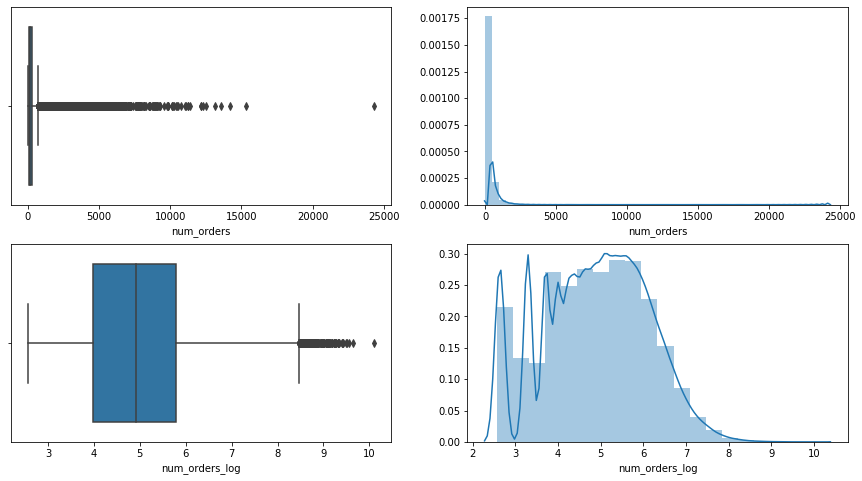

In [22]:
## Comparison between num_orders and log of num_orders
plt.figure(figsize = (15,8))
plt.subplot(2,2,1)
''' num_orders '''
sns.boxplot(train_df.num_orders) 
plt.subplot(2,2,2)
sns.distplot(train_df.num_orders, bins = 50)

plt.subplot(2,2,3)
''' num_orders_log '''
sns.boxplot(train_df.num_orders_log)
plt.subplot(2,2,4)
sns.distplot(train_df.num_orders_log, bins = 20)

plt.show()

### Weekly meal orders

In [23]:
results = train_df.groupby('week').sum()
weeks = train_df.week.unique() 

# Define function to plot all graphs relating to number of meal orders
def real(df, col):
    plt.figure(figsize = (14, 6))
    plt.plot(weeks, df[col],'.-')
    plt.xticks(weeks[::9])
    plt.ylabel(col)
    plt.xlabel('Week')

    ## Add horizontal mean line and above/below 1 std
    mean = df[col].mean()
    std = df[col].std()
    plt.axhline(y = mean, color = 'r', linestyle = '--')
    plt.axhline(y = mean + std, color = 'gray', linestyle = '--')
    plt.axhline(y = mean - std, color = 'gray', linestyle = '--')
    plt.axhline(y = mean + 2*std, color = 'gray', linestyle = '--')
    plt.axhline(y = mean - 2*std, color = 'gray', linestyle = '--')

    plt.title('Meal orders within 145 weeks')
    plt.show()

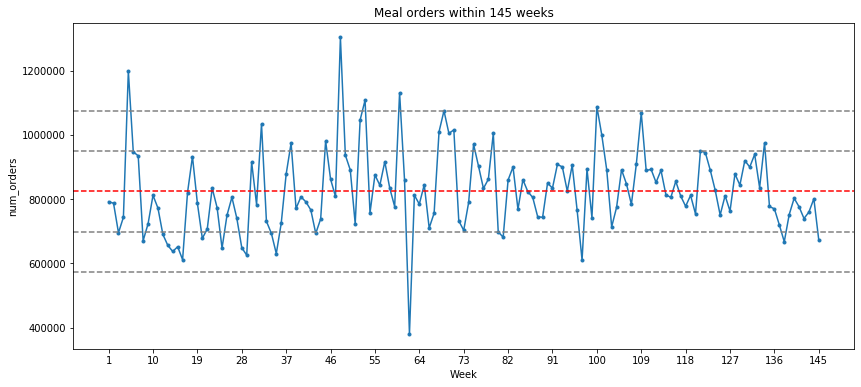

In [24]:
real(results,'num_orders')

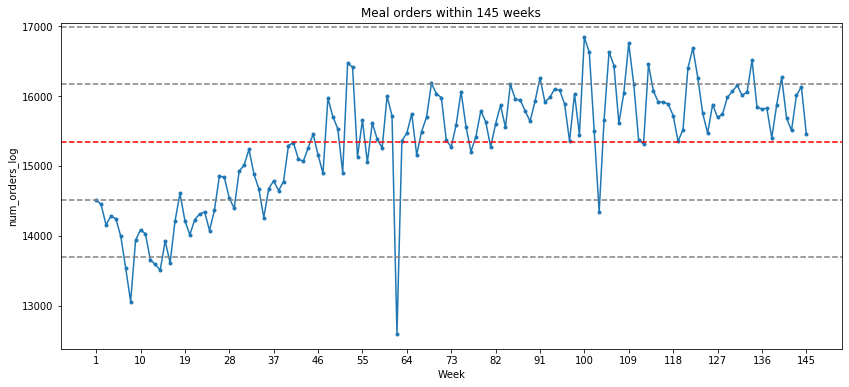

In [25]:
real(results,'num_orders_log')

**Using the log of num_orders can reduce lots of outliers**

## Visualize features and target variable

In [26]:
## Defirne the plots showing the correlation between feature and target variable

def plot_feature(df, col):
    ''' Plot differents categorical and numerical variables
        Above, distribution of sample on the feature
        below, correlation between number of meal orders on the feature
    '''
    plt.figure(figsize = (15,8))
    plt.subplot(2,1,1)
        ## Plots of numerical variables
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col].value_counts().sort_index().plot()
    
    else:
        ## Plots of categorical variables
        mean = df.groupby(col)['num_orders'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace = True)
        df[col].value_counts().plot(linewidth = 1)
    
    plt.xlabel(col)
    plt.ylabel('counts')
    
    plt.subplot(2,1,2)
    sns.barplot(x = col, y = 'num_orders', data = df)
    plt.xticks(rotation = 90)
    plt.ylabel('# Meal Orders')

    plt.show()

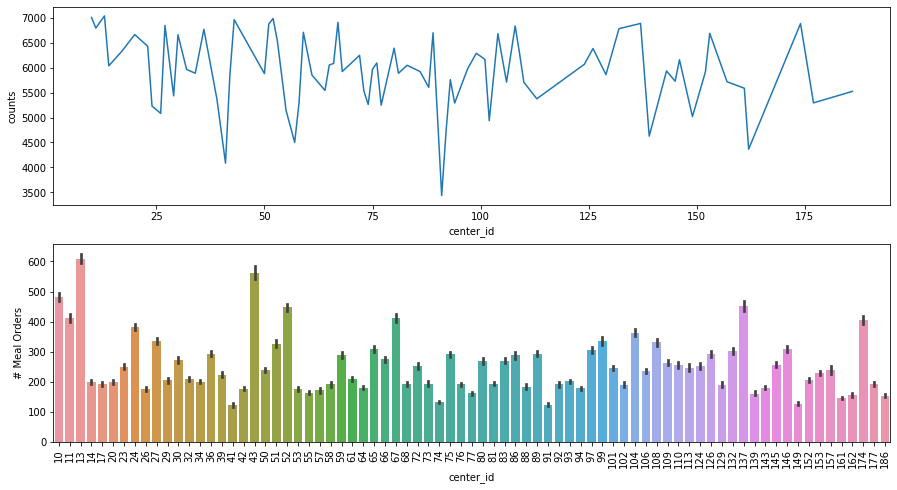

In [27]:
plot_feature(train_df, 'center_id')

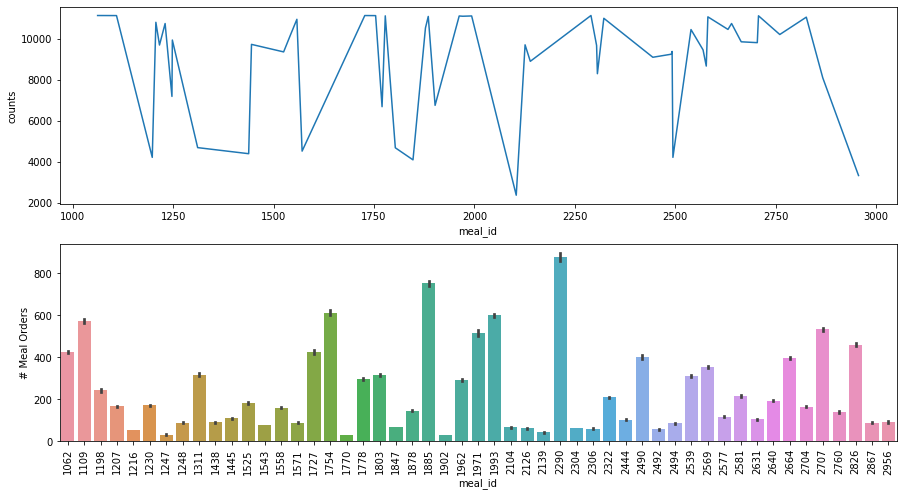

In [28]:
plot_feature(train_df, 'meal_id')

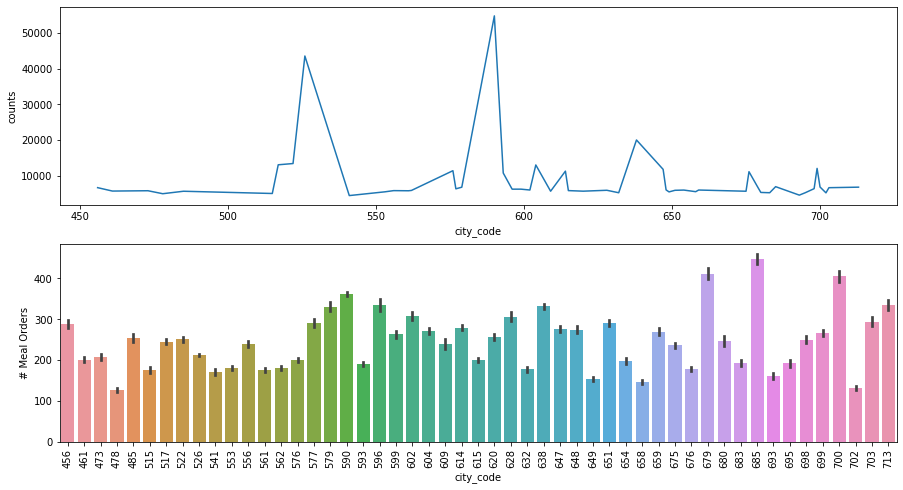

In [29]:
plot_feature(train_df, 'city_code')

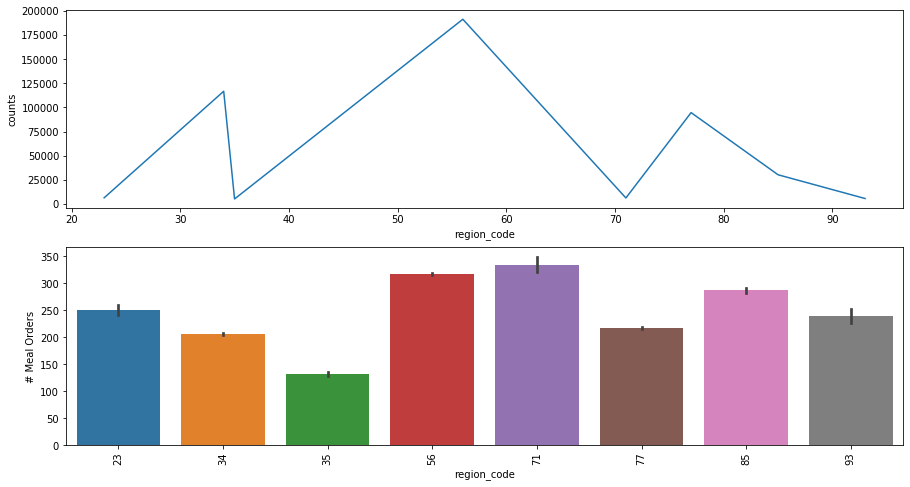

In [30]:
plot_feature(train_df, 'region_code')

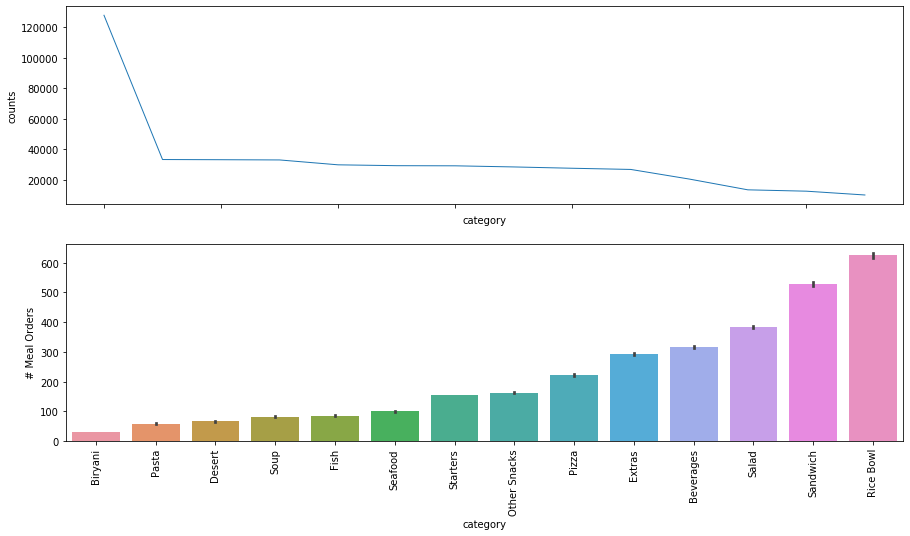

In [31]:
plot_feature(train_df, 'category')

**There is a strong correlation between category and meal orders**

Among the categories, Biryani was least ordered and Rice Bowl was the most prefered food

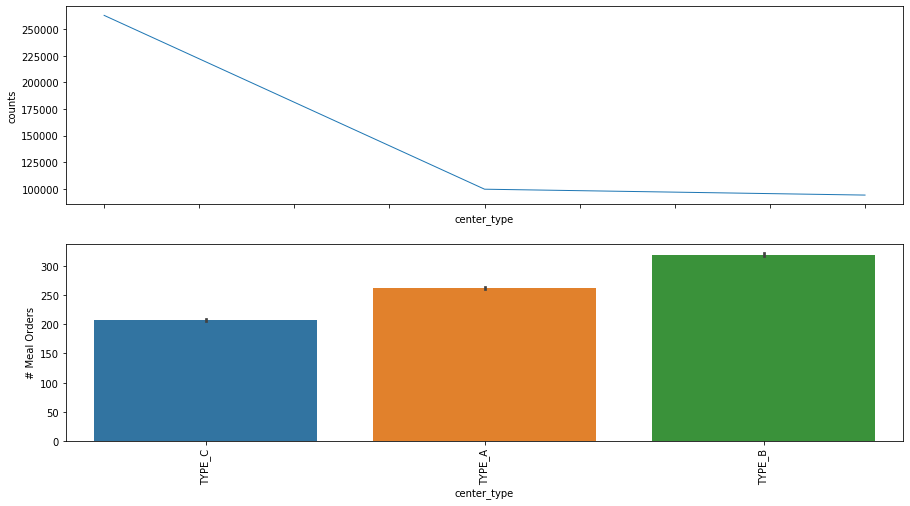

In [32]:
plot_feature(train_df, 'center_type')

**There is a strong correlation between center type and the meal orders**

Type B received the most orders during 145 weeks

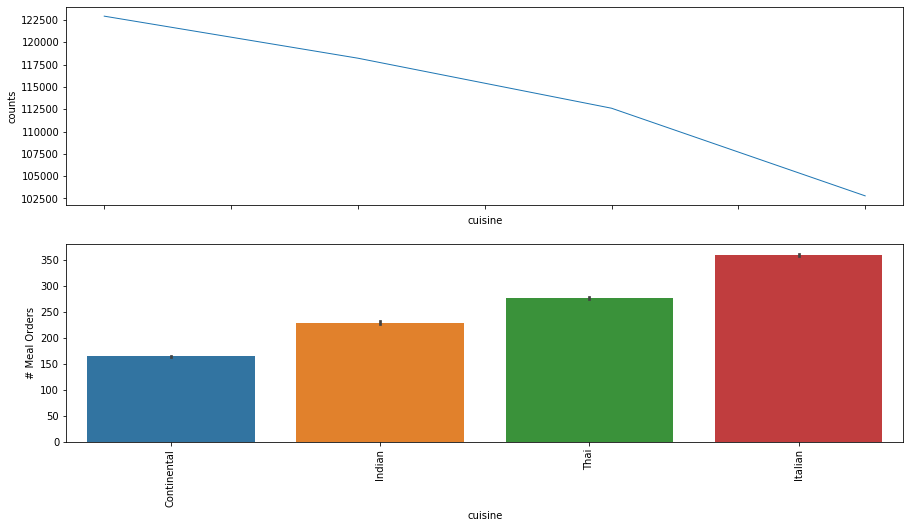

In [33]:
plot_feature(train_df, 'cuisine')

Among the cuisine, customers prefer Itailian food at most

## Examine the correlations

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   id                     456548 non-null  int64   
 1   week                   456548 non-null  int64   
 2   center_id              456548 non-null  int64   
 3   meal_id                456548 non-null  int64   
 4   checkout_price         456548 non-null  float64 
 5   base_price             456548 non-null  float64 
 6   emailer_for_promotion  456548 non-null  int64   
 7   homepage_featured      456548 non-null  int64   
 8   num_orders             456548 non-null  int64   
 9   city_code              456548 non-null  int64   
 10  region_code            456548 non-null  int64   
 11  center_type            456548 non-null  category
 12  op_area                456548 non-null  float64 
 13  category               456548 non-null  category
 14  cuisine             

In [35]:
## Encode the category by mean of num_orders_log 
def encode_label(df, col):
    cat_dict = {}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['num_orders'].mean()
    df[col] = df[col].map(cat_dict)

In [36]:
for col in train_df.columns:
    if train_df[col].dtype.name == 'category':
        encode_label(train_df, col)

In [37]:
for col in train_df.columns:
    if train_df[col].dtype.name == 'category':
        train_df[col] = train_df[col].astype('category').cat.codes

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  int8   
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  int8   
 14  cuisine                456548 non-nu

In [39]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,num_orders_log
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,0,2.0,10,2,5.176150
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,0,2.0,10,2,5.777652
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,0,2.0,10,2,4.564348
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,0,2.0,10,2,5.093750
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,0,2.0,10,2,5.370638


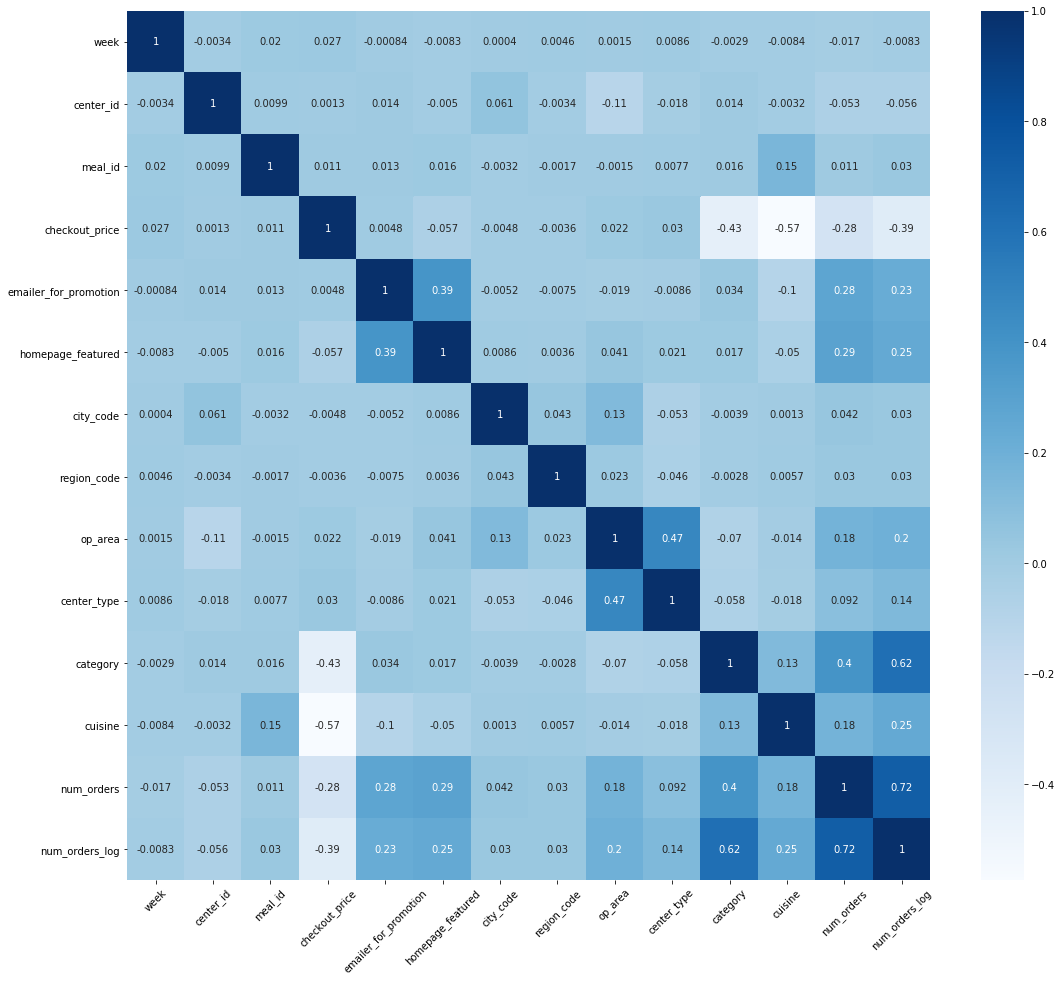

In [40]:
## Show correlation in matrix
## id is excluded because the its uniqueness
fig = plt.figure(figsize = (18, 16))
features = ['week', 'center_id', 'meal_id', 'checkout_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'op_area', 'center_type', 'category', 'cuisine','num_orders']
#features = train_df.columns.values[1:].tolist() 
''' Get all columns except the first col - unique id '''
sns.heatmap(train_df[features + ['num_orders_log']].corr(), cmap = 'Blues', annot = True)
plt.xticks(rotation = 45)

plt.show()

**The category, prices (negative trends), cuisine, homepage_featured, emailer_for_promotion and op_area** have the significant impacts on num_orders_log, sorted from highest to lowest in absolute margins

### Some initial insights

According to the EDA:
- The preferences (categories and cuisine) took important role in number of orders (maybe also relate to the citizen regions)
- The discount attracted the attention of customers to order more
- The marketing activities (homepage_featured and emailer_for_promotion) increased the meal orders 
- The center_id did not affect significantly the num_orders, instead the op_area 

**To reduce the fluctuation, we use the num_orders_log as label (target) to do regression in the next parts**

# PART 3 - DEVELOP THE BASELINES AND PROPOSED SOLUTIONS

**2 targets:**
- Feature importance
- Forward prediction for the next 10 weeks

## 3.1 - TARGET 1: THE IMPORTANT FACTORS IN MODEL

## A. CREATE THE BASELINE 

## Train and test the dataset

**Split the dataset in to train and test part to build up the predictive model**

### Feature engineering

In [41]:
# Remove some variables
results.drop(['id', 'base_price', 'num_orders'], axis = 1, inplace = True)

### Create the data variables for train and test

In [42]:
# Assign the x, y values
x = results.iloc[:, :8]
'''Exclude the num_orders_log column'''
y = results.num_orders_log
# get 30% public, 70% private (not random, due to the time-series outlook)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [43]:
print('length of x_train and x_test: ', len(x_train), len(x_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of x_train and x_test:  101 44
length of y_train and y_test:  101 44


In [44]:
# Define the plots comparing the actual and predicted values
def plot_compare(DataFrame, array):
    y_pred_a = pd.DataFrame(array)
    y_test_a = y_test.reset_index(drop = True, inplace = False)
    pred_df = pd.concat([y_test_a, y_pred_a], axis = 1).sort_values(1, axis = 1).reset_index(drop = True)
    pred_df.columns = ['Actual orders','Predicted orders' ]

    plt.figure(figsize = (6,6))

    # Output samples for prediction
    maxlimit = pred_df['Actual orders'].max() + 1000
    plt.xlim(13000, maxlimit)
    plt.ylim(13000, maxlimit)
    plt.scatter(pred_df['Actual orders'], pred_df['Predicted orders'], s=10)
    plt.plot([13000, maxlimit], [13000, maxlimit], ls = '--', c = '.3')
    plt.title('Actual and Predicted num_orders_log')
    plt.xlabel('Predicted orders')
    plt.ylabel('Actual orders')
    plt.show()

In [45]:
# Define the residual plot
def plot_residuals(DataFrame):
    plt.figure(figsize = (14, 6))

    error_train = lin.predict(x_train) - y_train
    error_test = lin.predict(x_test) - y_test
    plt.scatter(lin.predict(x_train), error_train,
                            color = 'g', s = 10, label = 'Train_data')
    plt.scatter(lin.predict(x_test), error_test,
                            s = 10, label = 'Test_data')

    maxlimit = lin.predict(x_train).max() + 1000
    plt.xlim(5000, maxlimit)

    # Add 0 line 
    plt.hlines(y = 0, xmin = 0, xmax = 17500, linewidth = 2, ls = '--')

    # Format the plot
    plt.legend(loc = 'upper left')
    plt.title('Residual Error')
    plt.show()

## B. PROPOSED SOLUTIONS 

## LINEAR REGRESSION MODEL

### Create and fit model for prediction

In [46]:
# regress the values linearly
lin = LinearRegression()

# training and predicting process
lin_train = lin.fit(x_train, y_train)
y_pred = lin.predict(x_test)

In [47]:
# Measure how well the data fits the model, the higher values - the better the independent variables can explain the target
lin_score = lin_train.score(x_train, y_train)
lin_score

0.9360598987155478

### Create coefficients

In [48]:
coef = lin.coef_

# Assign the components to show the magnitude in each variable
components = pd.DataFrame(zip(x.columns, coef), columns = ['components', 'value'])
components = components.append({'components': 'intercept', 'value': lin.intercept_}, ignore_index = True)
print(components)

              components        value
0              center_id     0.005955
1                meal_id    -0.001193
2         checkout_price    -0.002157
3  emailer_for_promotion     0.119209
4      homepage_featured     0.753682
5              city_code     0.045570
6            region_code     0.035339
7                op_area    -5.245622
8              intercept -1805.184311


### Evaluate Linear Regression prediction

In [49]:
## Measure the RMSE - evaluation metrics for the model predictions, the smaller RMSE - the better model
print('Linear Regression 100*RMSE = ', mean_squared_log_error(y_test, y_pred)*100)

Linear Regression 100*RMSE =  0.0123049136812459


**The 100*RMSLE is very small. This model is significant**

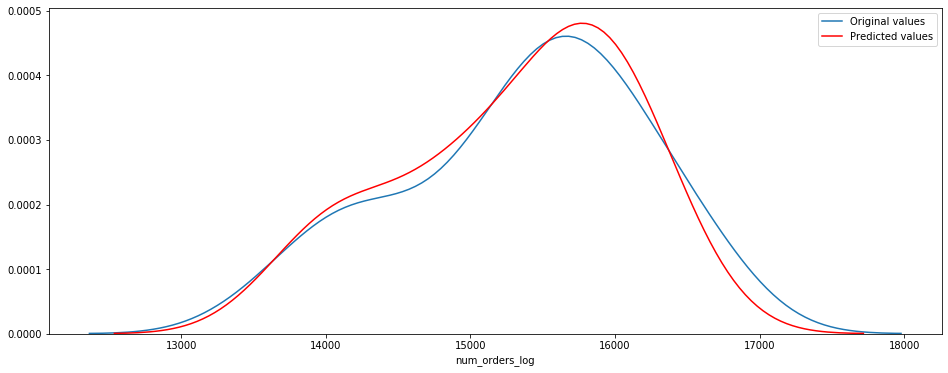

In [50]:
plt.figure(figsize = (16,6))
ax1 = sns.distplot(y_test, hist = False, label = 'Original values')
ax2 = sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted values')

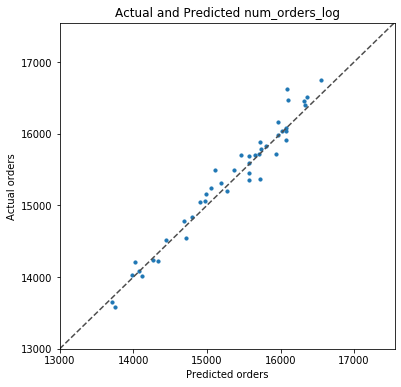

In [51]:
plot_compare(DataFrame, y_pred)

The graph shows how well the predicted values, compared to the actual values. This diagram represents the observed and predicted points seem to be linear positive distributed.

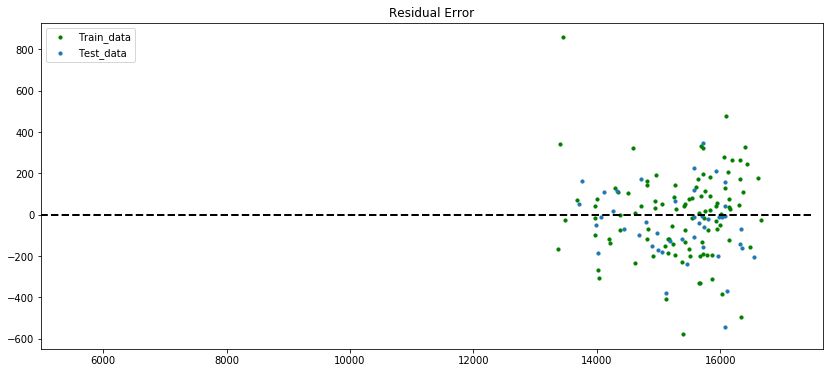

In [52]:
plot_residuals(DataFrame)

## RANDOM FOREST MODEL (DECISION TREES)

In [53]:
# Perform the Random Forest model
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Training and Predicting process
rf_train = rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

### Coefficient

In [54]:
coef_rf = lin.coef_
components_rf = pd.DataFrame(zip(x.columns, coef), columns = ['components', 'value'])
components_rf = components.append({'components': 'intercept', 'value': lin.intercept_}, ignore_index = True)
print(components_rf)

              components        value
0              center_id     0.005955
1                meal_id    -0.001193
2         checkout_price    -0.002157
3  emailer_for_promotion     0.119209
4      homepage_featured     0.753682
5              city_code     0.045570
6            region_code     0.035339
7                op_area    -5.245622
8              intercept -1805.184311
9              intercept -1805.184311


In [55]:
rf_score = rf_train.score(x_train, y_train)
rf_score

0.9802859153379402

### Evaluate Random Forest prediction

In [56]:
## Measure the RMSE 
print('Random Forest 100*RMSE = ', mean_squared_log_error(y_test, y_pred_rf)*100)

Random Forest 100*RMSE =  0.03181972168252317


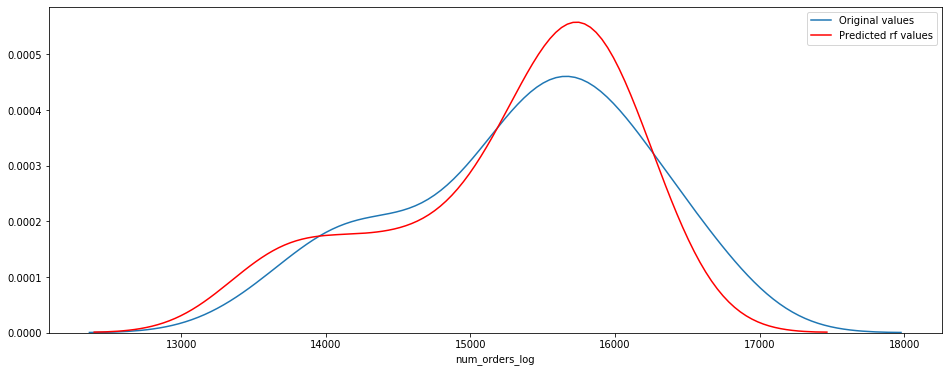

In [57]:
plt.figure(figsize = (16,6))
ax1 = sns.distplot(y_test, hist = False, label = 'Original values')
ax2 = sns.distplot(y_pred_rf, hist = False, color = 'r', label = 'Predicted rf values')

The predicted data is much steeper in the center and more mass in the left tail, compared to the original ones

**In general, both of models execute the small RMSE, but in comparison, even Linear approach has the lower score the Random Forest, its 100*RMSE is smaller than the latter**

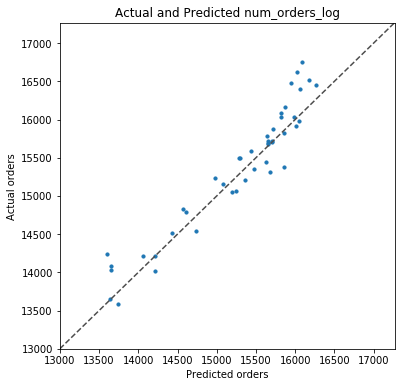

In [58]:
plot_compare(DataFrame, y_pred_rf)

This model show positive linear, but more diverse than the Linear model

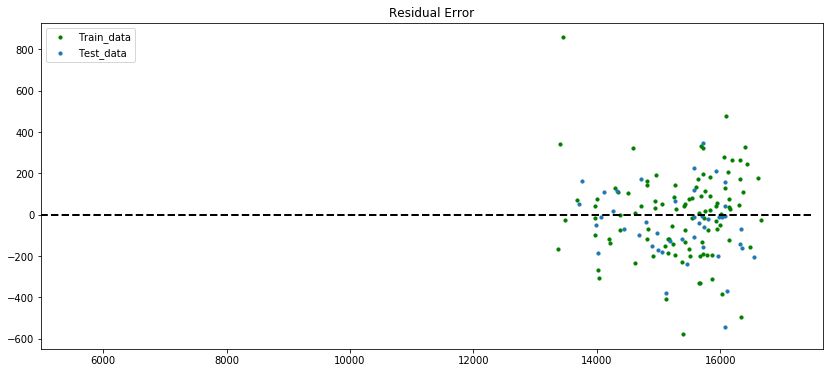

In [59]:
plot_residuals(DataFrame)

## C. BEST MODEL FOR FEATURE IMPORTANCE

**With the evaluation metrics 100*RMSE, the best model is the Linear Regression model with the smallest value**
- Linear Regression 100*RMSE =  0.0123049136812459
- Random Forest 100*RMSE =  0.03181972168252317

**Based on the benefit of Linear Regression model, to make prediction in the time-series, we apply ARIMA** 

## 3.2. TARGET 2: OUT-OF-SAMPLE FORECAST

## A. BASELINE IN TIME-SERIES MODELS 

## Estimate and eliminate the trend

Because the stationarity of dataset is an important assumption in the time-series (TS) analysis, we perform the Dickey-Fuller test to test the stationarity. Let have a look on two methods below
- **Moving Average (MA)**: take the number of consecutive values regarding frequency of TS and use the rolling technique with window 10 weeks
- **Exponential Weighted Moving Average (EWMA)**: assign the weights to all previous values with a decay factor

### Moving Average (MA) and stationarity test

In [60]:
# Define the rolling mean, std and stationarity test

def test_stationarity(time_series):
    
    # Determine the rolling statistics
    moving_average = time_series.rolling(window = 12).mean()
    moving_std = time_series.rolling(window = 12).std()
    
    # Visualize the rolling statisics
    plt.figure(figsize = (14, 6))
    
    origin = plt.plot(time_series, label = 'Original')
    mean = plt.plot(moving_average, color = 'r', label = 'Rolling mean')
    std = plt.plot(moving_std, color = 'g', label = 'Rolling std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation_Moving Average')
    plt.show(block = False)
    
    # Examine autocorrelation by Dickey-Fuller test
    print('Result of Dickey-Fuller test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '# lags used', 'Number of observations used'])

    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value

    print(dfoutput)
    

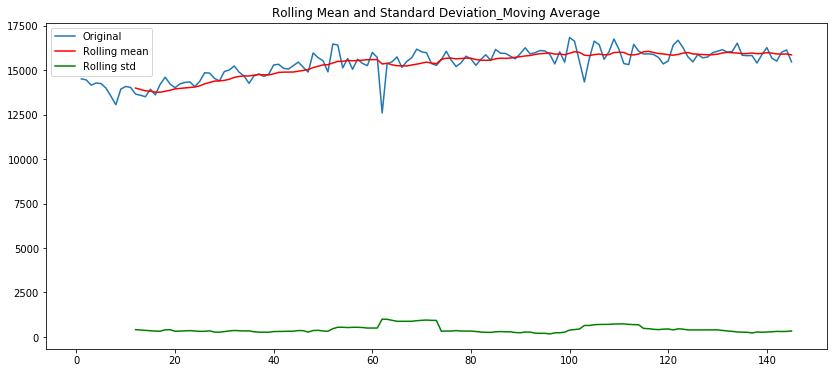

Result of Dickey-Fuller test:
Test Statistic                  -2.133610
p-value                          0.231216
# lags used                      7.000000
Number of observations used    137.000000
Critical value (1%)             -3.479007
Critical value (5%)             -2.882878
Critical value (10%)            -2.578149
dtype: float64


In [61]:
# Take the log transform
test_stationarity(results['num_orders_log'])

- The log of num_orders is not stationary 
- Compared to num_orders, the absolute std of num_orders_log is much larger than the num_orders but the std of former is flatter than that of the later
- As we see, the mean of num_order_log follows the trend

**Let see the difference between the moving average (MA) and the reality**

In [62]:
# Find the difference between the Moving Average (MA) and actual number
moving_average = results['num_orders_log'].rolling(window = 12).mean()
moving_std = results['num_orders_log'].rolling(window = 12).std()
    
difference_ma = results['num_orders_log'] - moving_average

# Remove the NaN values
difference_ma.dropna(inplace = True)
difference_ma.head()

week
12   -339.968609
13   -328.775096
14   -330.716814
15    107.033831
16   -151.098829
Name: num_orders_log, dtype: float64

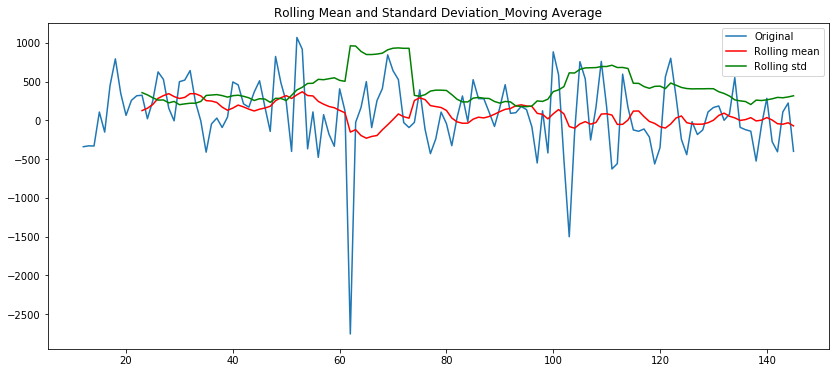

Result of Dickey-Fuller test:
Test Statistic                -9.070543e+00
p-value                        4.314168e-15
# lags used                    1.000000e+00
Number of observations used    1.320000e+02
Critical value (1%)           -3.480888e+00
Critical value (5%)           -2.883697e+00
Critical value (10%)          -2.578586e+00
dtype: float64


In [63]:
# Take the log transform
test_stationarity(difference_ma)

- The p-value is very small, so the test is significant
- Test statistics is much smaller than critical value at 1%. This data is stationary

### Exponential Weighted Moving Average (EWMA)
    

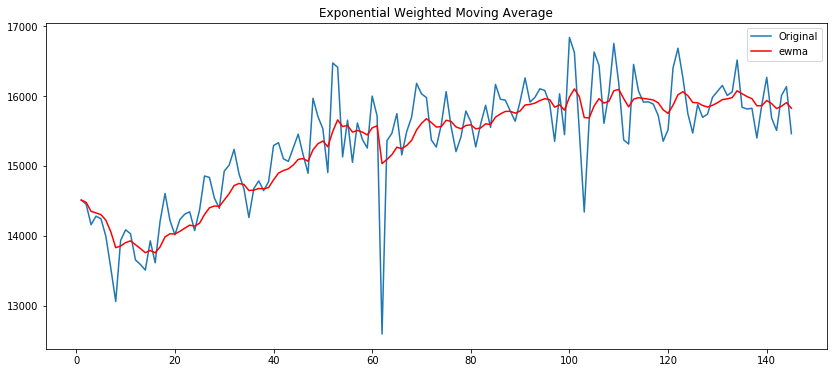

In [64]:
# Plot the EWMA into data
plt.figure(figsize = (14, 6))
ewma = results['num_orders_log'].ewm(span = 10).mean()

plt.plot(results['num_orders_log'], label = 'Original')
plt.plot(ewma, color = 'r', label = 'ewma')

plt.title('Exponential Weighted Moving Average')
plt.legend(loc = 'best')
plt.show()

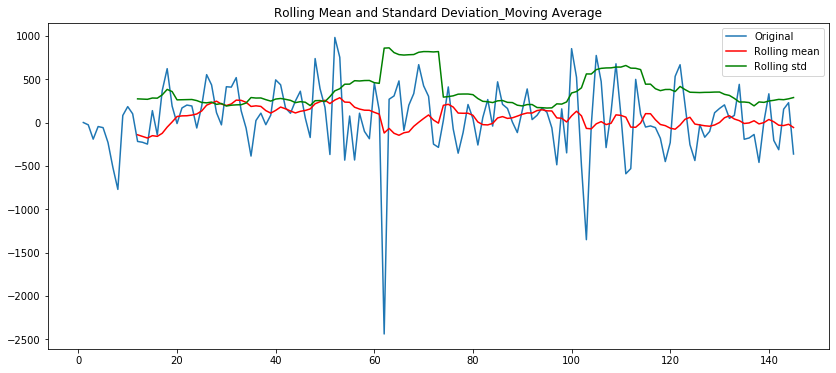

Result of Dickey-Fuller test:
Test Statistic                -1.027006e+01
p-value                        4.023370e-18
# lags used                    1.000000e+00
Number of observations used    1.430000e+02
Critical value (1%)           -3.476927e+00
Critical value (5%)           -2.881973e+00
Critical value (10%)          -2.577665e+00
dtype: float64


In [65]:
# Find the difference between the EWMA and actual number
difference_ewma = results['num_orders_log'] - ewma

# Test stationarity
test_stationarity(difference_ewma)

- The p-value of EWMA is larger than that of MA, but the value is also small
- The test statistics exceeds the critical values. Thus, the null hypothesis is not rejected and this is not stationary

**In conclusion, using MA is much better than EWMA**

## ARIMA model (Autoregressive Integrated Moving Average) 

Combine both AR and MA model, we examine the ARIMA model

Forecast for a stationary time-series in linear regresion model. We need to predict (p,d,q) equivalent to 
- **Number of Auto-Regressive (AR) - p**: lags of dependent variables (named x)
- **Number of Moving Average (MA) - q**: lagged forecast errors (difference between the reality and the predicted values) in the prediction equation
- **Number of Difference - d**: number of differences in lags

### Examine the autocorrelation in Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
This step is to examine the autocorrelation before performing the different models

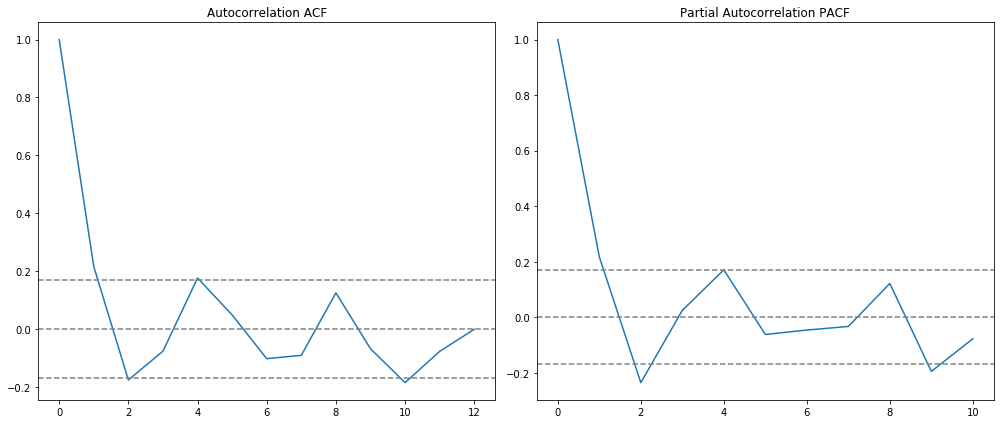

In [66]:
# Find the ACF and PACF
lag_acf = acf(difference_ma, nlags = 12, fft = False)
'''fft = False: not show the warning'''
lag_pacf = pacf(difference_ma, nlags = 10, method = 'ols')

# Visualize the ACF and PACF
plt.figure(figsize = (14, 6))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, color = 'gray', linestyle = '--')
plt.axhline(y = -1.96/np.sqrt(len(difference_ma)), color = 'gray', linestyle = '--')
plt.axhline(y = 1.96/np.sqrt(len(difference_ma)), color = 'gray', linestyle = '--')
plt.title('Autocorrelation ACF')
            
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, color = 'gray', linestyle = '--')
plt.axhline(y = -1.96/np.sqrt(len(difference_ma)), color = 'gray', linestyle = '--')
plt.axhline(y = 1.96/np.sqrt(len(difference_ma)), color = 'gray', linestyle = '--')
plt.title('Partial Autocorrelation PACF')

plt.tight_layout()

In the plot, two dotted lines are boundaries or confidence interval (alpha = 5%). We have the results:
- p = 1: the lag where PACF crosses the upper bound for the first time. 
- q = 1: the lag where ACF crosses the upper confidence interval for the first time. 

### ARIMA model

In [67]:
# Tuning arima model (p,d,q) - best option with lowest 100*RMSE
def evaluate_arima(x, arima_order):
    # show the train and test set in a fixed set
    train_size = int(len(x)*0.7)
    train, test = x[0:train_size], x[train_size:]
    history = [x for x in train]
    
    # do forecasts
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order) 
        arima = model.fit(disp = 0)
        y_hat = arima.forecast()[0]
        predictions.append(y_hat)
        history.append(test[t])
        
    # Information about the error term
    error = mean_squared_log_error(test, predictions)*100
    return error

# Choose the best (p,d,q)
def evaluate_models(df, p_values, d_values, q_values):
    df = df.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima(df, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA RMSE = %.4f' %(order, rmse))
                except:
                    continue
    print('Best ARIMA%s 100*RMSE=%.4f' % (best_cfg, best_score))
    
# Assign parameters:
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3)

warnings.filterwarnings("ignore")
evaluate_models(y.values, p_values, d_values, q_values)

Best ARIMA(2, 1, 1) 100*RMSE=0.0773


In [68]:
# Best the model ARIMA(2, 1, 1)
model = ARIMA(y, order = (2,1,1))
arima = model.fit(method = 'css', trend = 'c', disc = 0)
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.num_orders_log   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1074.264
Method:                           css   S.D. of innovations            466.985
Date:                Wed, 06 May 2020   AIC                           2158.527
Time:                        22:41:13   BIC                           2173.306
Sample:                             3   HQIC                          2164.533
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12.7205      6.920      1.838      0.066      -0.842      26.283
ar.L1.D.num_orders_log     0.1950      0.098      1.997      0.046       0.004       0.386
ar.L

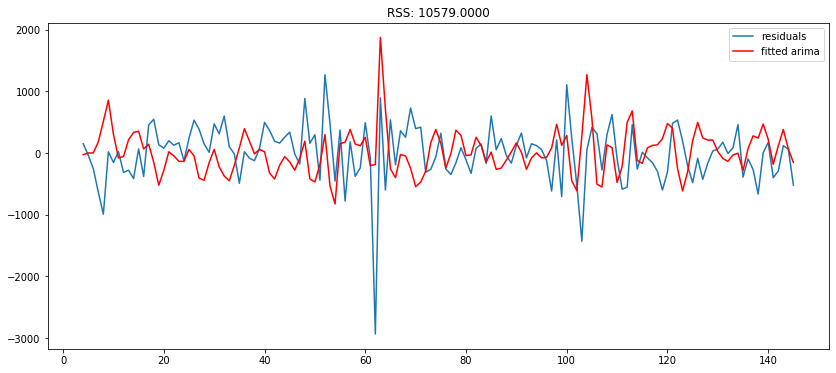

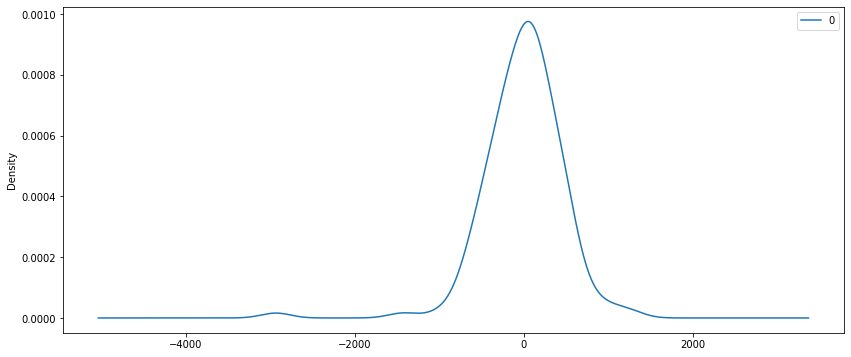

                 0
count   142.000000
mean     -5.382690
std     468.607315
min   -2934.672173
25%    -260.917272
50%      27.008264
75%     250.431711
max    1268.933396


In [69]:
# Plot the model
rcParams['figure.figsize'] = 14, 6
residuals = DataFrame(arima.resid)
plt.plot(residuals, label = 'residuals')
plt.plot(arima.fittedvalues, color = 'r', label = 'fitted arima')
RSS = sum((arima.fittedvalues - residuals)**2)
plt.title('RSS: %.4f'% RSS)
plt.legend(loc = 'best')
plt.show()

residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

We have the large Residual Sum of Squares (RSS) or huge sum of errors. 

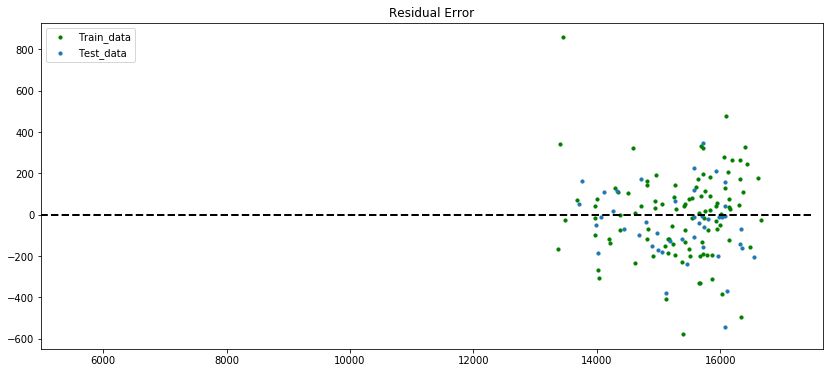

In [70]:
plot_residuals(DataFrame)

# PART 4: DEPLOY SOLUTION

## 4.1. THE IMPORTANT FEATURES

## Apply Linear Regression in entire set

In [71]:
# Regress the values linearly
lin = LinearRegression()

# Apply linear regression for the entire data
best_train = lin.fit(x, y)
best_pred = lin.predict(x)

In [72]:
lin_score = lin_train.score(x_train, y_train)
lin_score

0.9360598987155478

In [73]:
# New prediction with best_pred values
d = {'num_orders_log': y, 'expected': best_pred}
new_pred = pd.DataFrame(d)
new_pred

,num_orders_log,expected
week,,
1,14511.095180,14457.503621
2,14451.724265,14445.156849
3,14157.788027,14273.685237
4,14280.315662,13985.763856
5,14243.999122,14264.550202
...,...,...
141,15684.297011,15597.506882
142,15507.440466,15453.997444
143,16009.283679,16002.624795


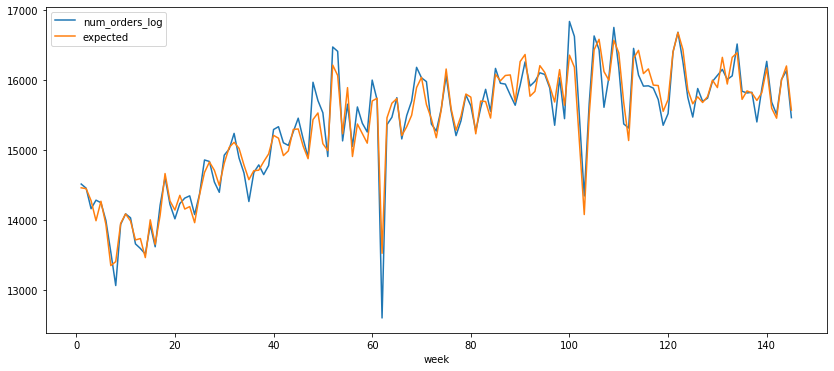

In [74]:
new_pred.plot()
plt.show()

In [75]:
## Measure the RMSE 
print('Linear Regression 100*RMSE = ', mean_squared_log_error(y, best_pred)*100)

Linear Regression 100*RMSE =  0.016706851683268038


## The important feature

In [76]:
coef_lin = lin.coef_

# Assign the components to show the magnitude in each variable
components = pd.DataFrame(zip(x.columns, coef), columns = ['components', 'value'])
components = components.append({'components': 'intercept', 'value': lin.intercept_}, ignore_index = True)
print(components)

              components        value
0              center_id     0.005955
1                meal_id    -0.001193
2         checkout_price    -0.002157
3  emailer_for_promotion     0.119209
4      homepage_featured     0.753682
5              city_code     0.045570
6            region_code     0.035339
7                op_area    -5.245622
8              intercept -2008.716007


**The most important features are op_area with negative impact (around 5.2) and homepage_featured with positive high coeficient (approximately 0.75) on the increase of meal orders**

## 4.2. OUT-OF-SAMPLE FORECAST - ARIMA MODEL 

<Figure size 1008x432 with 0 Axes>

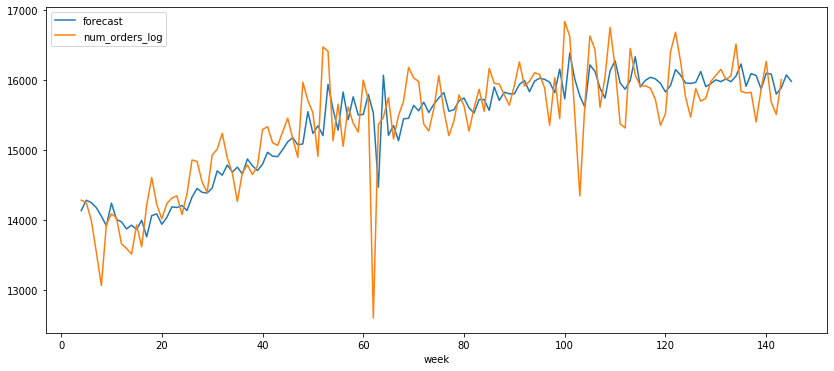

In [77]:
# Overview in-sample prediction
plt.figure(figsize = (14, 6))
arima.plot_predict(dynamic = False)
plt.show()

In [78]:
# Create the difference between t and (t-1) (stationarity)
def difference(df, interval = 1):
    diff = list()
    for i in range(interval, len(df)):
        value = df[i] - df[i - interval]
        diff.append(value)
    return np.array(diff)

# Make the train model to add value of the observation 1 year ago
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

# Seasonal difference
y = results.num_orders_log.values
weeks_in_year = 52

differenced = difference(y, weeks_in_year)

In [79]:
# Fit model
model = ARIMA(differenced, order = (2,1,1))
model_fit = model.fit(disp = 0)

# Out-of-sample forecast (forward 10 steps)
forecast = model_fit.forecast(steps = 10)[0]

# loop the observation to get values in weeks 146-155
history = [x for x in y]
week = 146
for yhat in forecast:
    inverted = inverse_difference(history, yhat, weeks_in_year)
    print('Week %d: %f' %(week, inverted))
    history.append(inverted)
    week += 1

Week 146: 15831.197495
Week 147: 16037.999380
Week 148: 15820.119667
Week 149: 15203.326126
Week 150: 15850.670923
Week 151: 15260.111967
Week 152: 16640.566210
Week 153: 16406.989524
Week 154: 15257.848177
Week 155: 14083.645009


In [80]:
# Convert list into dataframe
df = pd.DataFrame(history, columns = ['full'])

# Start the row index with 1 instead of 0
df.index = df.index + 1

# Reset name of column to get the week column - with the target to merge other data
df = df.reset_index().rename(columns = {'index': 'week'})

#df = df.groupby('week').sum() ## remove the first column
df['num_orders_log'] = df.full[:145]
df['forecast'] = df.full[144:]

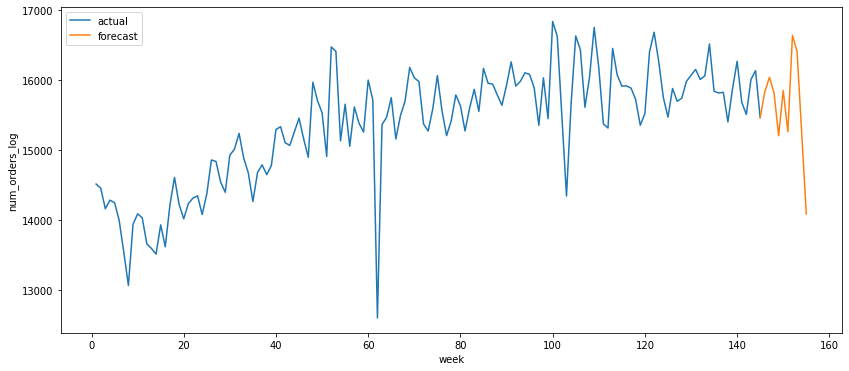

In [81]:
# Plot the actual values and predictions
plt.plot(df.week, df.num_orders_log, label = 'actual')
plt.plot(df.week, df.forecast, label = 'forecast')
plt.xlabel('week')
plt.ylabel('num_orders_log')
plt.legend()
plt.show()